In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tqdm as tqdm

In [3]:
import sys
import os

# # Add the poligrain and mergeplg src directories to Python's path
sys.path.insert(0, os.path.abspath("./mergeplg/src"))
sys.path.insert(0, os.path.abspath("./poligrain/src"))
sys.path.insert(0, os.path.abspath("./pycomlink"))

# Import submodules
import pycomlink as pycml
import poligrain as plg
from mergeplg import interpolate, merge

In [4]:
# OpenMRG
ds_gauges = xr.open_dataset('./data/gauges/gauge_15min.nc')
ds_rad = xr.open_dataset('./data/radar/radar_15min.nc')
ds_cmls = xr.open_dataset('./data/cml/cml_15min.nc')
ds_pws = xr.open_dataset('./data/netatmo/netatmo_rain_15min.nc')


In [5]:
# Focus on small time window
start = "2015-07-25T12:30"
end = "2015-07-25T15:00"

ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 
ds_pws = ds_pws.sel(time = slice(start, end)) 


# Project data

In [6]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

# Project rain gauge 
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

# Project CML 
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Project radar 
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = plg.spatial.project_point_coordinates( 
    ds_rad.lon, ds_rad.lat, ref_str
)

# Project PWS
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    ds_pws.lon, ds_pws.lat, ref_str
)


# Estimate rainfall fields

In [7]:
# Define variogram parameters used by kriging
variogram_parameters = {"sill": 1, "range": 30000, "nugget": 0.3}
variogram_model = "spherical"

# Number of neighbours to use for interpolation
nnear = 12

In [8]:
# Interpolate PWS data
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_radar,
    ds_gauges=ds_pws,
    full_line=False,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_pws.time.data:
    rainfall.append(
        interpolator(
            da_gauges=ds_pws.sel(time=time).R,
        )
    )
ds_rad["rainfall_InterpolatePWS"] = xr.concat(rainfall, dim="time")

In [9]:
# Interpolate CML data
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=False,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.R.sel(time=time),
        )
    )
ds_rad["rainfall_InterpolateCML"] = xr.concat(rainfall, dim="time")

In [10]:
# Merge PWS and radar data using additive merging
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar,
    ds_gauges=ds_pws,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="additive",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_gauges=ds_pws.sel(time=time).R,
        )
    )
ds_rad["rainfall_MergeAdditivePWS"] = xr.concat(rainfall, dim="time")

In [11]:
# Merge CML and radar data using additive merging
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="additive",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_MergeAdditiveCML"] = xr.concat(rainfall, dim="time")

In [20]:
# Merge PWS and radar using kriging with external drift
merger = merge.MergeKrigingExternalDrift(
    ds_rad=ds_rad.rainfall_radar,
    ds_gauges=ds_pws,
    variogram_parameters=variogram_parameters,
    nnear=60,
    full_line=False,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_gauges=ds_pws.sel(time=time).R,
        )
    )
ds_rad["rainfall_MergeKEDPWS"] = xr.concat(rainfall, dim="time")

In [21]:
# Merge CML and radar using kriging with external drift
merger = merge.MergeKrigingExternalDrift(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    variogram_parameters=variogram_parameters,
    nnear=60,
    full_line=False,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_MergeKEDCML"] = xr.concat(rainfall, dim="time")

# Plot rainfall fields

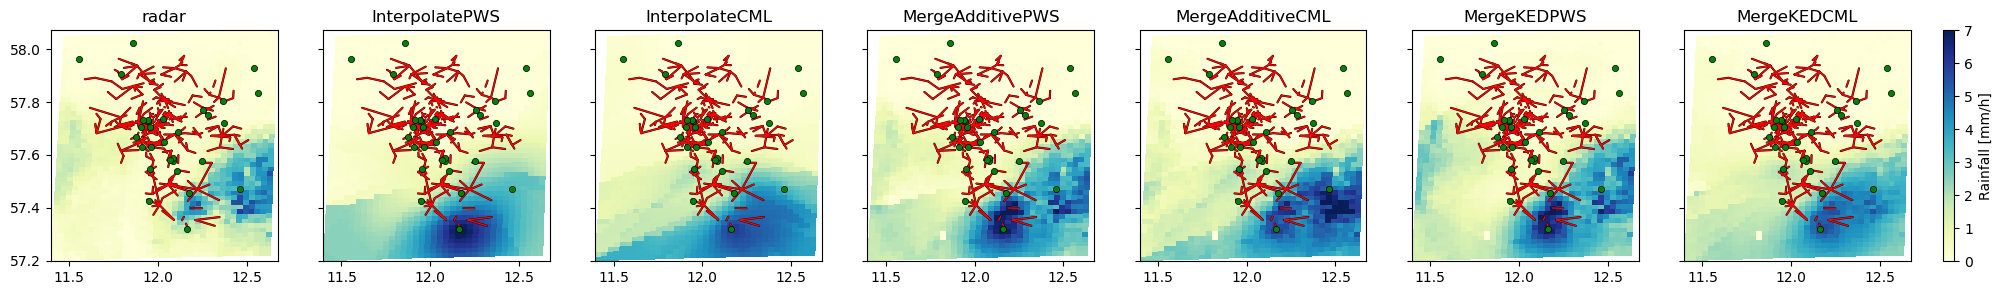

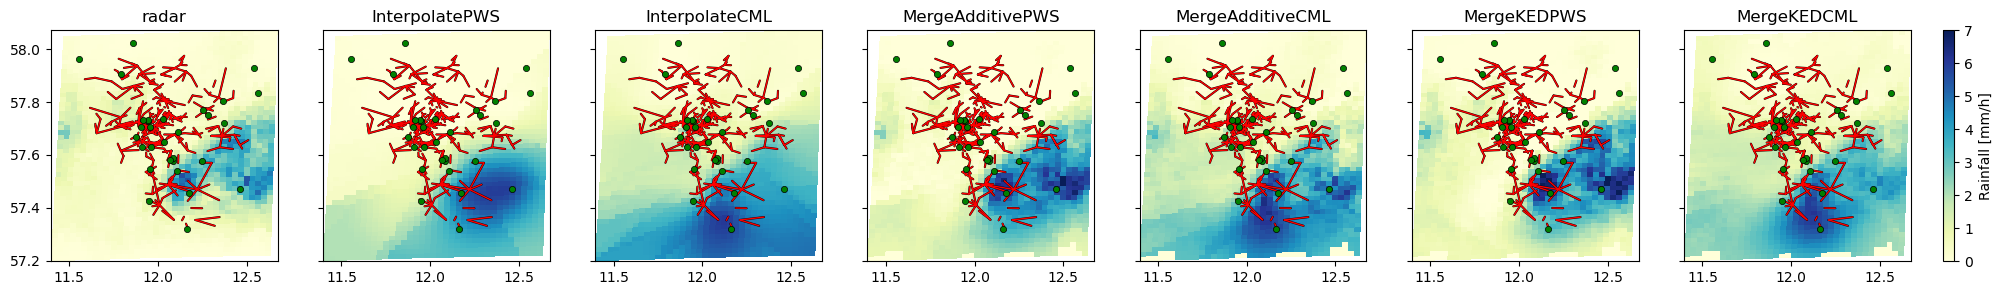

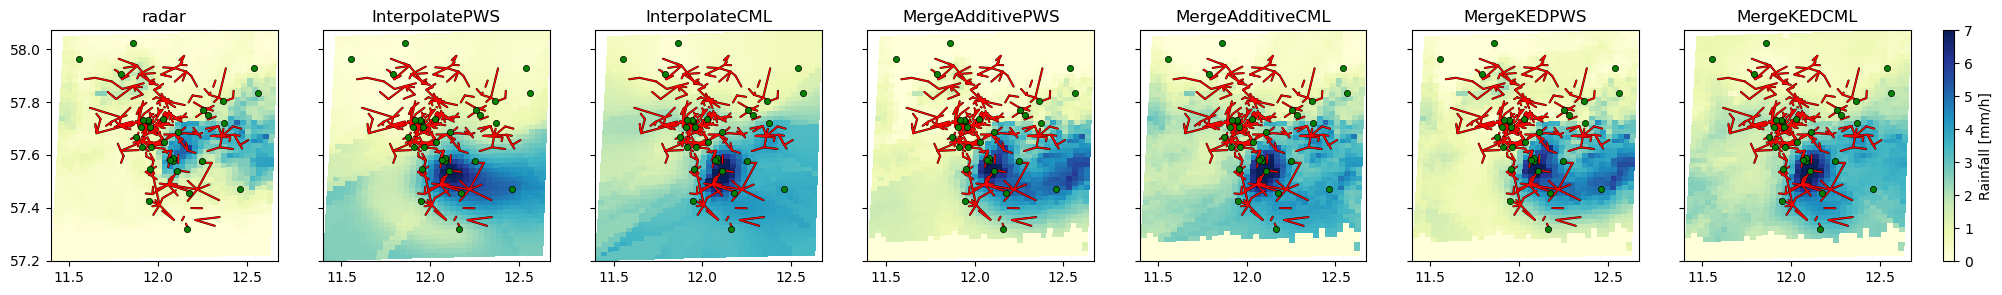

In [22]:
vmax = 7  # max color

# Time interval to plot
time_start = "2015-07-25T12:30"
time_end = "2015-07-25T13:30"

# Rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    "rainfall_InterpolatePWS",
    "rainfall_InterpolateCML",
    "rainfall_MergeAdditivePWS",
    "rainfall_MergeAdditiveCML",
    "rainfall_MergeKEDPWS",
    "rainfall_MergeKEDCML",
]

for time in ds_cmls.sel(time=slice(time_start, time_end)).time[:3]:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(30, 3), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad.lon,
            ds_rad.lat,
            ds_rad[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap="YlGnBu",
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls,
            use_lon_lat=True,
            ax=ax[i],
            line_color="r",
        )
        
        # Plot position PWS
        plg.plot_map.plot_plg(
            da_gauges=ds_pws,
            use_lon_lat=True,
            ax=ax[i],
            point_color="g",
        );

        # Set title
        ax[i].set_title(rainfall_field.split("_")[1])

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("Rainfall [mm/h]")
    plt.show()

# Compare to rain gauges

In [23]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges.R,
    )

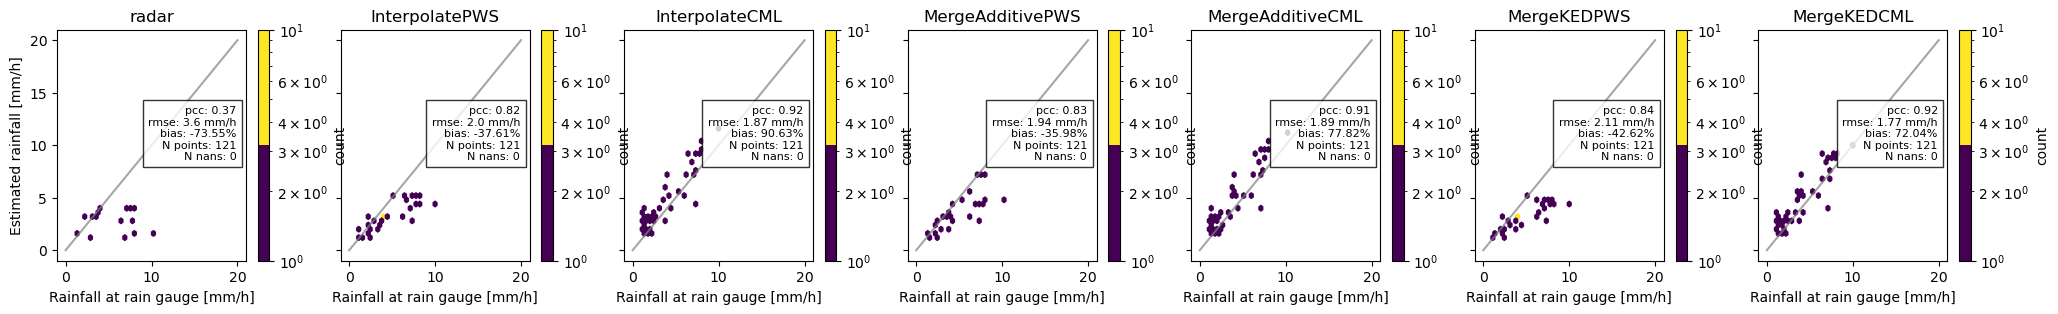

In [25]:
# Plot
threshold = 1  # Estimates below this are ignored
ground_truth = ds_gauges.R.data.flatten()

fig, ax = plt.subplots(
    1, len(rainfall_fields), figsize=(25, 3), sharey=True, sharex=True
)
for i, rainfall_field in enumerate(rainfall_fields):
    # Get predictions at test gauges
    predicted = ds_gauges[rainfall_field].to_numpy().flatten()

    # plotting the scatter density plots
    hx = plg.validation.plot_hexbin(
        ground_truth,
        predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
        ax=ax[i],
    )

    ax[i].set_title(rainfall_field.split("_")[1])
    if i == 0:
        ax[i].set_ylabel("Estimated rainfall [mm/h]")
    else:
        ax[i].set_ylabel("")
    ax[i].set_xlabel("Rainfall at rain gauge [mm/h]")

    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=ground_truth,
        estimate=predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
    )

    # adding metrics to the plot for subplot 0
    plotted_metrics = (
        f"pcc: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )

    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )